# Holme-Kim Graph (PA Clustering)

### Libraries

In [8]:
## Basic
from tqdm import tqdm_notebook as tqdm
import argparse
import os
import random
import itertools

# Computation
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import MinMaxScaler

import scipy
from scipy.stats.stats import pearsonr 

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Network Processing
import networkx as nx
from networkx.generators import random_graphs

## node colour
color_map = ["steelblue"]

### Supporting Functions

In [9]:
## supporting functions
from support.preprocessing import sort_adjacency, reshape_A, calculate_A_shape, reconstruct_adjacency, pad_matrix, unpad_matrix, prepare_in_out
from support.metrics import compute_mig, compute_mi
from support.graph_generating import generate_single, generate_manifold, generate_topol_manifold, generate_topol_manifold
from support.param_generating import generate_param_graph_manifold, generate_param_topol_manifold
from support.latent_space import vis2D, visDistr

## import model
from models.VAE import VAE

## Loading and Preprocessing Network Data

### Loading Network Data

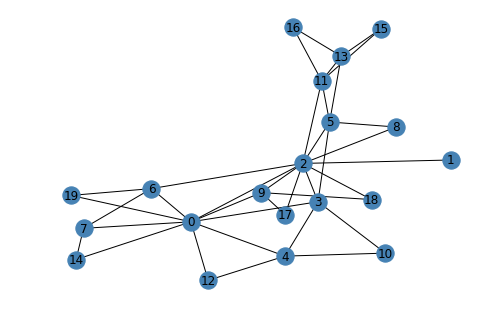

In [10]:
def get_graph(n,e,p,draw): 

    # n nodes
    # e number of edges to attach from new node to existing node
    # p probability of adding a triangle after adding a random edge

    g = random_graphs.powerlaw_cluster_graph(n, e, p, seed=None)

    if draw:
        nx.draw(g, node_color = color_map, with_labels = True)
        plt.show()
    
    return g

g = get_graph(n = 20, e = 2, p = 0.8, draw = True)

# Generating Training Data

In [11]:
def generate_data(dataArgs): 
    
    ## Data ________________________________

    G = np.zeros((dataArgs["n_graphs"], *calculate_A_shape(dataArgs["n_max"], diag_offset = dataArgs["diag_offset"])))

    ## Ground Truth Labels ______________________________

    T = list()
    T_array = np.zeros((dataArgs["n_graphs"],3))

    ## Generate Graph Data_______________________________

    for i in tqdm(range(0,dataArgs["n_graphs"])):

        ## Generate Graph Type ______________________________________________

        if dataArgs["fix_n"] == True:
            n = dataArgs["n_max"] # generate fixed number of nodes n_max
        else:
            n = random.randint(1, dataArgs["n_max"]) # generate number of nodes n between 1 and n_max and

        e = random.randint(1, n)
        p = np.random.rand(1)  # float in range 0 - 1 
        g = get_graph(n, e, p, draw = False)

        g, a = sort_adjacency(g)
        a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal
        a_transformed = reshape_A(a, diag_offset = dataArgs["diag_offset"])


        ## Build Data Arrays___________________________________________________

        G[i] = a_transformed

        t = dict()
        t["n"] = n
        t["e"] = e
        t["p"] = p
        
        T_array[i] = [n,e,p]
        T.append(t)



    ## Input and Output Size ___________________________________________________________

    T, input_shape, output_shape = prepare_in_out(T, dataArgs["diag_offset"], calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"]))
    print("input_shape:", input_shape, ", output_shape:", output_shape)
    
    ## scale parameters in T_array for smoother training
    scaler = MinMaxScaler()
    scaler.fit(T_array)
    T_array = scaler.transform(T_array)
    
    return G,T,T_array,input_shape,output_shape,scaler
    
dataArgs = {"n_graphs": 10000, "n_max": 24, "fix_n": False, "diag_offset": 0, "diag_value": 1, "clip": True}  #"diag_offset" - 1 == full adjacency
G, T, T_array, input_shape, output_shape,scaler = generate_data(dataArgs)


input_shape: (300,) , output_shape: 300


# beta-VAE (MLP, 2D_Conv)

## Build and Train Model

In [12]:
# network parameters
modelArgs = {"nn_architecture": "mlp", "param_loss": True, "latent_dim": 2, "growth_param": T_array.shape[1], "filters": 16, "kernel_size": 3, "input_shape": input_shape, "output_shape": output_shape}
trainArgs = {"beta": 20, "loss": "binary_crossentropy", "weights": "train", "early_stop": 2, "batch_size": 128, "epochs": 50, "data_split": 0.2}

vae = VAE(modelArgs, trainArgs, G, T_array)

models = vae.model 
data = vae.data

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 300)          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 128)          38528       encoder_input[0][0]              
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 64)           8256        dense_7[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            130         dense_8[0][0]                    
__________________________________________________________________________________________________
z_log_var 

# Latent Space Analysis

# Encoder

# Iterate through single data dimension and oberseve single latent space dimension  

Mutual Information Gap: 0.7742048007132706


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:355: RuntimeWarning: divide by zero encountered in double_scalars


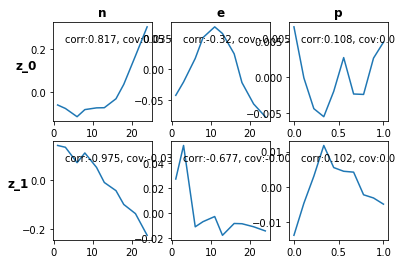

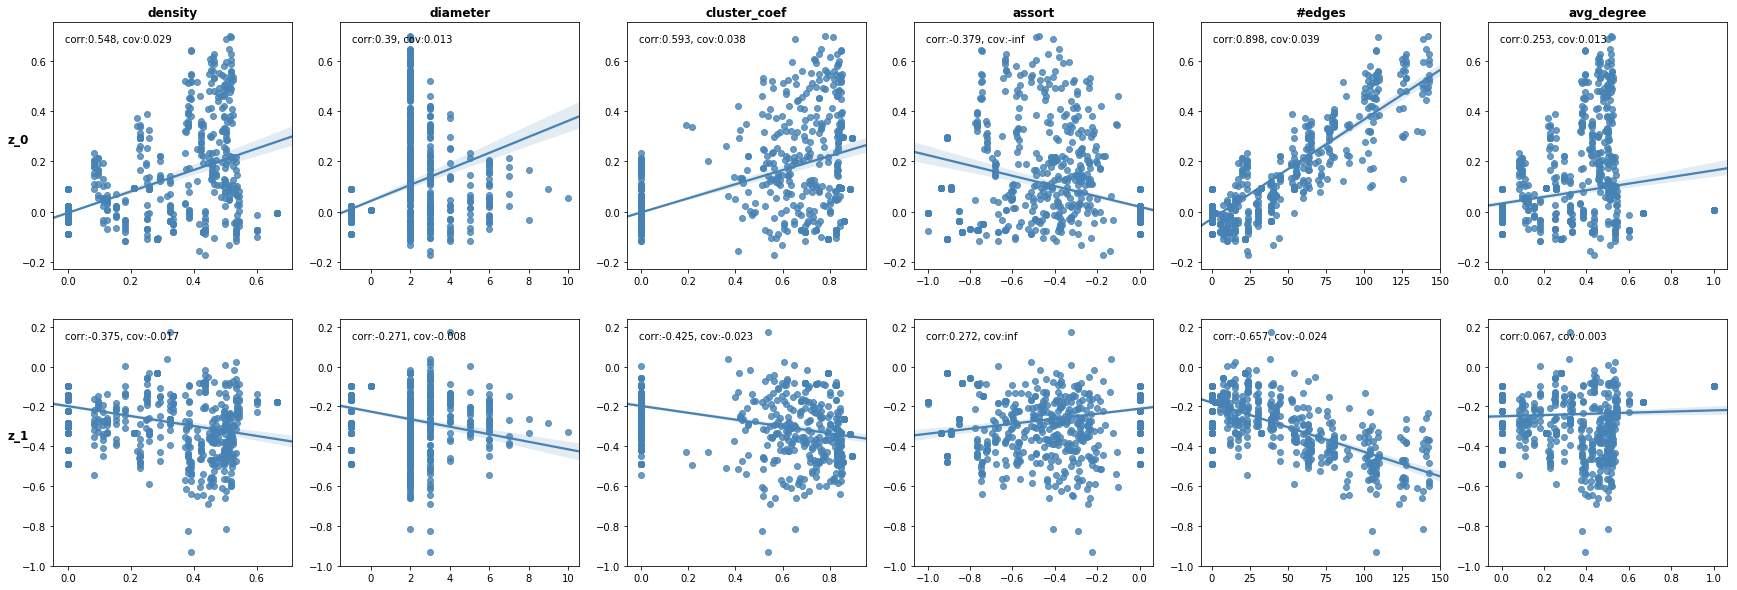

In [13]:
def latent_space_feature_correlation(analyzeArgs, modelArgs, models,batch_size=128,model_name="vae_graph"):

    if modelArgs["param_loss"]:
        encoder, graph_decoder, param_decoder = models  # trained models
    else:
        encoder, graph_decoder = models  # trained models
        

    if analyzeArgs["root_params"] == 2:
        
        ## Generate Graph Data_______________________________
    
        #N = np.linspace(1,dataArgs["n_max"],analyzeArgs["n_config_graphs"], dtype=int)  # array 1,2,3,4,5 - n_max / n_config_graphs
        n = dataArgs["n_max"]
        E = np.linspace(1,n,analyzeArgs["n_config_graphs"], dtype=int)  
        P = np.linspace(0,1,analyzeArgs["n_config_graphs"])  # array 0.1, 0.2 - 1 / n_config_graphs 

        ## growth and topol parameters
        growth_params = ["e", "p"]
        topol_params = ["density", "diameter", "cluster_coef", "assort", "#edges", "avg_degree"]

        ## store graphs and targets
        # shape: n_config_graphs, params, upper_A_size
        G = np.zeros((analyzeArgs["n_config_graphs"]**len(growth_params), *calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"])))
        Growth = np.zeros((analyzeArgs["n_config_graphs"]**len(growth_params), len(growth_params)))
        Topol = np.zeros((analyzeArgs["n_config_graphs"]**len(growth_params), len(topol_params)))

        ## iterate through topological features
        graph_configs = np.asarray(list(itertools.product(E,P)))
        

        for i, (e,p) in enumerate(graph_configs):

            ## Generate Graph Type ______________________________________________
            
            g = get_graph(int(n), int(e), p, draw = False)

            g, a = sort_adjacency(g)
            a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal
            upper_a = reshape_A(a, dataArgs["diag_offset"])


            ## Generate Ground Truth features____________________________________

            density = nx.density(g)

            if nx.is_connected(g):
                diameter = nx.diameter(g)
            else:
                diameter = -1

            cluster_coef = nx.average_clustering(g)

            if g.number_of_edges() > 0:
                assort = nx.degree_assortativity_coefficient(g, x='out', y='in')
            else:
                assort = 0

            edges = g.number_of_edges()

            avg_degree = sum(i for i in nx.degree_centrality(g).values()) / len(nx.degree_centrality(g).keys())


            ## toDO: add more graph topologies

            ## Build Data Arrays___________________________________________________

            G[i] = upper_a

            Growth[i,0] = int(e)
            Growth[i,1] = p

            Topol[i,0] = density
            Topol[i,1] = diameter
            Topol[i,2] = cluster_coef
            Topol[i,3] = assort
            Topol[i,4] = edges
            Topol[i,5] = avg_degree
  
    
        ## ENCODER - 2D Digit Classes ______________________________________________

        # display a 2D plot of the digit classes in the latent space
        z_mean, _, _ = encoder.predict(G, batch_size = batch_size)
        
                
        ## Measure the Mutual Information Gap ____________________________________________
        if analyzeArgs["metric"] == "mig":
            #mi = compute_mi(P, np.squeeze(z_mean))
            mig = compute_mig(Growth, z_mean)
        
        
        ##  Reshape Array according to Parameters  
        z_mean_growth = np.reshape(z_mean, (analyzeArgs["n_config_graphs"], analyzeArgs["n_config_graphs"], -1))
        Growth = np.reshape(Growth,(analyzeArgs["n_config_graphs"], analyzeArgs["n_config_graphs"], -1))
            
        ## 1.) Growth Parameters________________________________________________________

        ## Visualize Latent Variables x Growth Parameters ____________________________

        fig, ax = plt.subplots(nrows= z_mean_growth.shape[-1] , ncols= len(growth_params))

        for latent_z, row in enumerate(ax):        
            for feature, col in enumerate(row):
                
                if feature == 0:
                    feature_1 = 1
                if feature == 1:
                    feature_1 = 0

                y = np.mean(z_mean_growth[:,:,latent_z], axis= feature_1)
                x = np.mean(Growth[:,:,feature], axis= feature_1)
                col.plot(x, y)  

                ## compute correlation and standardized covariance
                corr = round(pearsonr(x,y)[0],3)
                cov = round(np.cov(x, y)[0][1]/max(x),3)
                col.annotate("corr:"+str(corr)+", cov:"+str(cov), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')


        ## add row and column titles _____________________

        rows = ['z_{}'.format(row) for row in range(z_mean_growth.shape[-1])]
        cols = [t for t in growth_params]

        for axis, col in zip(ax[0], cols):
            axis.set_title(col, fontweight='bold')

        for axis, row in zip(ax[:,0], rows):
            axis.set_ylabel(row, rotation=0, size='large', fontweight='bold')



        ## 2.) Graph Topologies________________________________________________________

        ## Visualize Latent Variables x Growth Parameters ____________________________

        ##  Reshape Array according to Parameters  
        #Topol = np.reshape(Topol,(n_config_graphs, n_config_graphs, -1))

        fig, ax = plt.subplots(nrows= z_mean.shape[-1] , ncols= len(topol_params), figsize=(30,10))

        for latent_z, row in enumerate(ax):        
            for feature, col in enumerate(row):

                ## toDO: change sorting
                y = z_mean[:,latent_z]
                x = Topol[:,feature]
                sns.regplot(x, y, color="steelblue", ax=col)
                #col.scatter(x, y) 

                # set axes range
                #plt.xlim(-4, 4)
                #plt.ylim(-4, 4)

               # try:
               #     ## plot trend line
               #     x = np.nan_to_num(x)
               #     y = np.nan_to_num(y)

               #     z = np.polyfit(x, y, 1)
               #     p = np.poly1d(z)
               #     col.plot(x,p(x),"steelblue")
               # except:
               #     pass


                ## compute correlation and standardized covariance
                corr = round(pearsonr(x,y)[0],3)
                cov = round(np.cov(x, y)[0][1]/max(x),3)
                col.annotate("corr:"+str(corr)+", cov:"+str(cov), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')



        ## add row and column titles _____________________

        rows = ['z_{}'.format(row) for row in range(z_mean.shape[-1])]
        cols = [t for t in topol_params]

        for axis, col in zip(ax[0], cols):
            axis.set_title(col, fontweight='bold')

        for axis, row in zip(ax[:,0], rows):
            axis.set_ylabel(row, rotation=0, size='large', fontweight='bold')


            
            
            
    if analyzeArgs["root_params"] == 3:
        
        ## Generate Graph Data_______________________________
    
        N = np.linspace(1,dataArgs["n_max"],analyzeArgs["n_config_graphs"], dtype=int)  # array 1,2,3,4,5 - n_max / n_config_graphs
        E = np.linspace(1,dataArgs["n_max"],analyzeArgs["n_config_graphs"], dtype=int)  
        P = np.linspace(0,1,analyzeArgs["n_config_graphs"])  # array 0.1, 0.2 - 1 / n_config_graphs 

        ## growth and topol parameters
        growth_params = ["n", "e", "p"]
        topol_params = ["density", "diameter", "cluster_coef", "assort", "#edges", "avg_degree"]

        ## store graphs and targets
        # shape: n_config_graphs, params, upper_A_size
        G = np.zeros((analyzeArgs["n_config_graphs"]**len(growth_params), *calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"])))
        Growth = np.zeros((analyzeArgs["n_config_graphs"]**len(growth_params), len(growth_params)))
        Topol = np.zeros((analyzeArgs["n_config_graphs"]**len(growth_params), len(topol_params)))

        ## iterate through topological features
        graph_configs = np.asarray(list(itertools.product(N,E,P)))
        

        for i, (n,e,p) in enumerate(graph_configs):

            ## Generate Graph Type ______________________________________________
            try:
                g = get_graph(int(n), int(e), p, draw = False)
            except:
                g = get_graph(int(n), int(n), p, draw = False)

            g, a = sort_adjacency(g)
            a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal
            upper_a = reshape_A(a, dataArgs["diag_offset"])


            ## Generate Ground Truth features____________________________________

            density = nx.density(g)

            if nx.is_connected(g):
                diameter = nx.diameter(g)
            else:
                diameter = -1

            cluster_coef = nx.average_clustering(g)

            if g.number_of_edges() > 0:
                assort = nx.degree_assortativity_coefficient(g, x='out', y='in')
            else:
                assort = 0

            edges = g.number_of_edges()

            avg_degree = sum(i for i in nx.degree_centrality(g).values()) / len(nx.degree_centrality(g).keys())


            ## toDO: add more graph topologies

            ## Build Data Arrays___________________________________________________

            G[i] = upper_a

            Growth[i,0] = int(n)
            Growth[i,1] = int(e)
            Growth[i,2] = p

            Topol[i,0] = density
            Topol[i,1] = diameter
            Topol[i,2] = cluster_coef
            Topol[i,3] = assort
            Topol[i,4] = edges
            Topol[i,5] = avg_degree
  
    
        ## ENCODER - 2D Digit Classes ______________________________________________

        # display a 2D plot of the digit classes in the latent space
        z_mean, _, _ = encoder.predict(G, batch_size = batch_size)
        
                
        ## Measure the Mutual Information Gap ____________________________________________
        if analyzeArgs["metric"] == "mig":
            #mi = compute_mi(P, np.squeeze(z_mean))
            mig = compute_mig(Growth, z_mean)
        
        
        ##  Reshape Array according to Parameters  
        z_mean_growth = np.reshape(z_mean, (analyzeArgs["n_config_graphs"], analyzeArgs["n_config_graphs"], analyzeArgs["n_config_graphs"], -1))
        Growth = np.reshape(Growth,(analyzeArgs["n_config_graphs"], analyzeArgs["n_config_graphs"], analyzeArgs["n_config_graphs"], -1))
            
        ## 1.) Growth Parameters________________________________________________________

        ## Visualize Latent Variables x Growth Parameters ____________________________

        fig, ax = plt.subplots(nrows= z_mean_growth.shape[-1] , ncols= len(growth_params))

        for latent_z, row in enumerate(ax):        
            for feature, col in enumerate(row):
                
                if feature == 0:
                    feature_1, feature_2 = 1, 2
                if feature == 1:
                    feature_1, feature_2 = 0, 2
                if feature == 2:
                    feature_1, feature_2 = 0, 1
                
                y = np.mean(z_mean_growth[:,:,:,latent_z], axis= (feature_1, feature_2)) - np.mean(z_mean_growth[:,:,:,latent_z])
                x = np.mean(Growth[:,:,:,feature], axis= (feature_1, feature_2))
                col.plot(x, y)  

                ## compute correlation and standardized covariance
                corr = round(pearsonr(x,y)[0],3)
                cov = round(np.cov(x, y)[0][1]/max(x),3)
                col.annotate("corr:"+str(corr)+", cov:"+str(cov), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')


        ## add row and column titles _____________________

        rows = ['z_{}'.format(row) for row in range(z_mean_growth.shape[-1])]
        cols = [t for t in growth_params]

        for axis, col in zip(ax[0], cols):
            axis.set_title(col, fontweight='bold')

        for axis, row in zip(ax[:,0], rows):
            axis.set_ylabel(row, rotation=0, size='large', fontweight='bold')



        ## 2.) Graph Topologies________________________________________________________

        ## Visualize Latent Variables x Growth Parameters ____________________________

        ##  Reshape Array according to Parameters  
        #Topol = np.reshape(Topol,(n_config_graphs, n_config_graphs, -1))

        fig, ax = plt.subplots(nrows= z_mean.shape[-1] , ncols= len(topol_params), figsize=(30,10))

        for latent_z, row in enumerate(ax):        
            for feature, col in enumerate(row):

                ## toDO: change sorting
                y = z_mean[:,latent_z]
                x = Topol[:,feature]
                sns.regplot(x, y, color="steelblue", ax=col)
                #col.scatter(x, y) 

                # set axes range
                #plt.xlim(-4, 4)
                #plt.ylim(-4, 4)

               # try:
               #     ## plot trend line
               #     x = np.nan_to_num(x)
               #     y = np.nan_to_num(y)

               #     z = np.polyfit(x, y, 1)
               #     p = np.poly1d(z)
               #     col.plot(x,p(x),"steelblue")
               # except:
               #     pass


                ## compute correlation and standardized covariance
                corr = round(pearsonr(x,y)[0],3)
                cov = round(np.cov(x, y)[0][1]/max(x),3)
                col.annotate("corr:"+str(corr)+", cov:"+str(cov), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')



        ## add row and column titles _____________________

        rows = ['z_{}'.format(row) for row in range(z_mean.shape[-1])]
        cols = [t for t in topol_params]

        for axis, col in zip(ax[0], cols):
            axis.set_title(col, fontweight='bold')

        for axis, row in zip(ax[:,0], rows):
            axis.set_ylabel(row, rotation=0, size='large', fontweight='bold')




## PLOT RESULTS ________________________________________

                        # 2,3
analyzeArgs = {"root_params": 3, "n_config_graphs": 10, "metric": "mig"}
latent_space_feature_correlation(analyzeArgs, modelArgs, models, batch_size=trainArgs["batch_size"], model_name="vae_mlp")

## Visualize the Latent Space in 2D

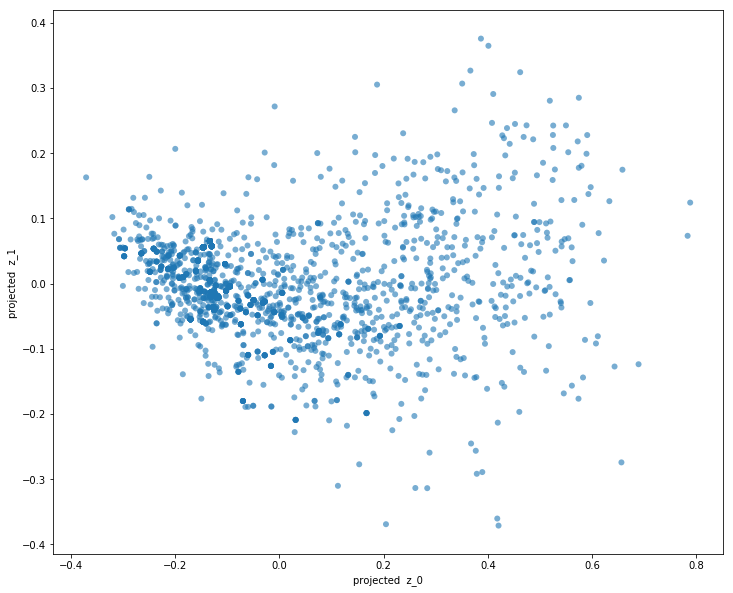

In [14]:
analyzeArgs = {"save_plots": False}
vis2D(analyzeArgs, modelArgs, models, data, batch_size=trainArgs["batch_size"], model_name="vae_mlp")

## Visualize Latent Generative Distribution

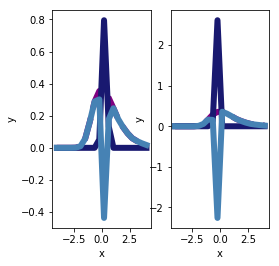

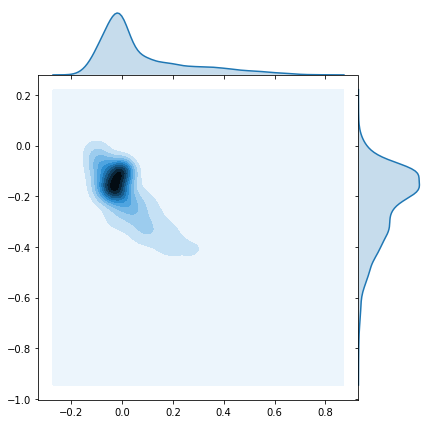

In [15]:
analyzeArgs = {"z": [0,1]}
visDistr(modelArgs, analyzeArgs, models,data,trainArgs["batch_size"])

# Decoder

## Generate a Single Graph Instance

latent dimensions: 2


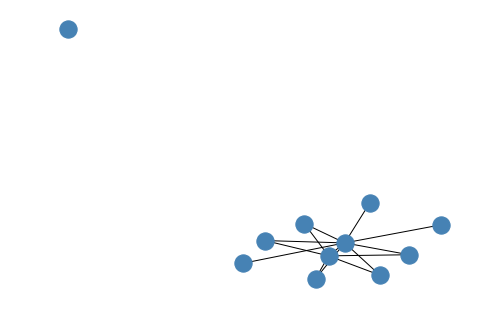

In [16]:
analyzeArgs = {"activations": [0, 0.2], "z": [0,1]}
generate_single(analyzeArgs, modelArgs, dataArgs, models, color_map)

## Generate Interpolated Manifold from Latent Space

latent dimensions: 2


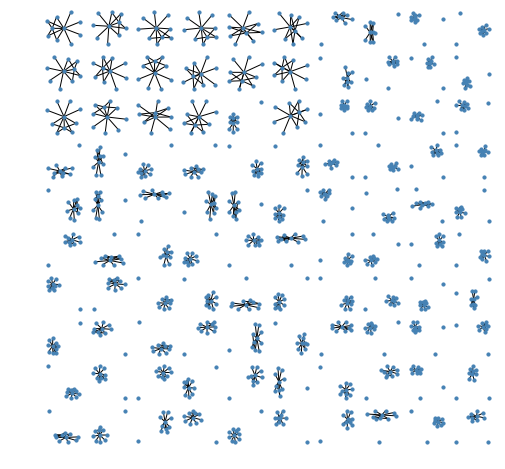

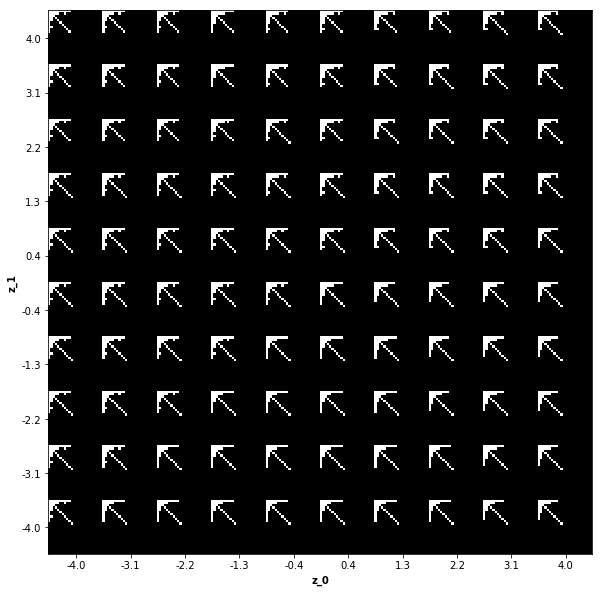

In [17]:
# range, normal, z
analyzeArgs = {"z": [0,1], "sample": "range", "act_range": [-4, 4], "act_scale": 1, "size_of_manifold": 10, "save_plots": False}
generate_manifold(analyzeArgs, modelArgs, dataArgs, models, data, color_map, batch_size=trainArgs["batch_size"])

latent dimensions: 2


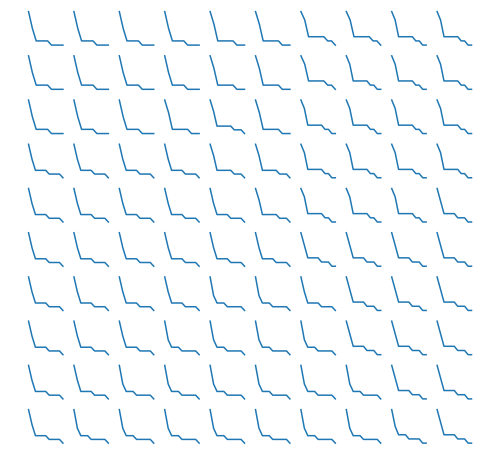

In [18]:
analyzeArgs = {"z": [0,1], "plot": "distr", "sample": "range", "act_range": [-4, 4], "act_scale": 1, "size_of_manifold": 10, "save_plots": False}
generate_topol_manifold(analyzeArgs, modelArgs, dataArgs, models, data, color_map, batch_size=trainArgs["batch_size"])

## "density", "cluster_coef", "assort", "avg_degree"

## Analyze Parameter Encoding

latent dimensions: 2
23 11 1.0
23 7 1.0
23 1 0.7710314
23 1 0.6234772
23 1 0.4773197
23 1 0.13533823
23 1 0.0
23 1 0.0
23 1 0.0
23 1 0.0
23 11 1.0
23 7 0.98868984
23 1 0.70492965
23 1 0.55737543
23 1 0.41121787
23 1 0.06923643
23 1 0.0
23 1 0.0
23 1 0.0
23 1 0.0
23 12 1.0
23 8 0.94967854
23 2 0.6659183
23 1 0.5183641
23 1 0.37220648
23 1 0.03022507
23 1 0.0
23 1 0.0
23 1 0.0
23 1 0.0
20 12 1.0
22 9 0.87961334
23 3 0.595853
23 1 0.4482988
23 1 0.30214125
23 1 0.0
23 1 0.0
23 1 0.0
23 1 0.0
23 1 0.0
5 5 0.861373
6 6 0.6793964
9 5 0.39563617
10 2 0.24808197
12 1 0.10192438
15 1 0.0
18 1 0.0
19 1 0.0
21 1 0.0
23 1 0.0
4 4 0.85170126
6 6 0.6697247
8 5 0.38596436
10 2 0.2384102
11 1 0.09225261
14 1 0.0
17 1 0.0
19 1 0.0
20 1 0.0
23 1 0.0
1 1 0.7931063
1 1 0.6111297
4 4 0.3273694
5 2 0.17981522
7 1 0.033657636
10 1 0.0
13 1 0.0
14 1 0.0
16 1 0.0
23 1 0.0
1 1 0.71899825
1 1 0.5370217
1 1 0.2532614
1 1 0.105707206
1 1 0.0
4 1 0.0
7 1 0.0
9 1 0.0
10 1 0.0
20 1 0.0
1 1 0.7066238
1 1 0.5246472
1 1

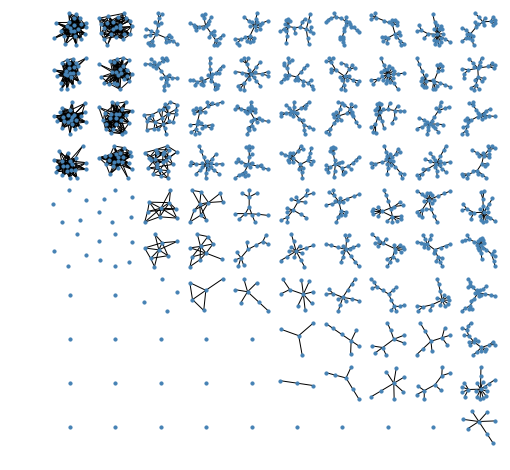

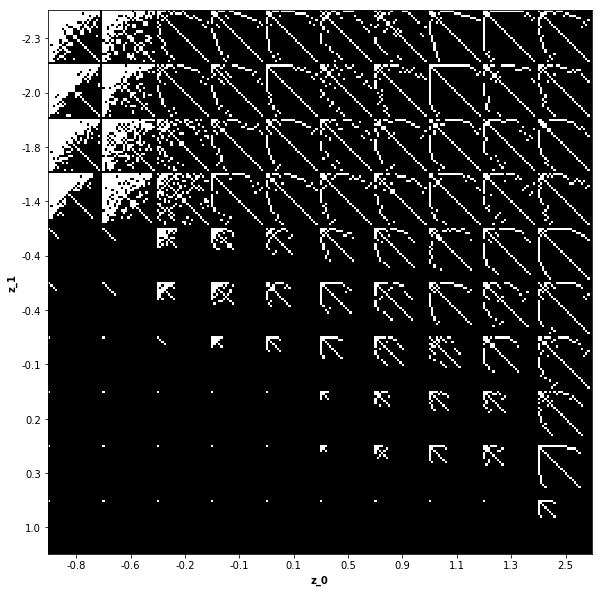

In [36]:
## range, normal, z
analyzeArgs = {"z": [0,1], "graph_type": "HK", "sample": "normal", "act_range": [-4, 4], "act_scale": 1, "size_of_manifold": 10, "save_plots": False}
generate_param_graph_manifold(analyzeArgs, modelArgs, dataArgs, models, data, color_map, trainArgs["batch_size"], scaler)

## "cluster_coef", "assort", "avg_degree"

latent dimensions: 2
20 15 1.0
23 5 0.73725563
23 1 0.462861
23 1 0.45738512
23 1 0.0
23 1 0.0
23 1 0.0
23 1 0.0
23 1 0.0
23 1 0.0
12 12 1.0
16 6 0.6331713
19 1 0.35877663
19 1 0.35330078
23 1 0.0
23 1 0.0
23 1 0.0
23 1 0.0
23 1 0.0
23 1 0.0
5 5 1.0
10 7 0.5463087
12 1 0.27191404
13 1 0.2664382
20 1 0.0
21 1 0.0
23 1 0.0
23 1 0.0
23 1 0.0
23 1 0.0
1 1 0.9548139
4 4 0.46537125
6 2 0.19097655
6 2 0.18550068
14 1 0.0
15 1 0.0
19 1 0.0
21 1 0.0
21 1 0.0
23 1 0.0
1 1 0.9224792
1 1 0.43303648
4 3 0.15864176
4 2 0.15316588
12 1 0.0
13 1 0.0
17 1 0.0
18 1 0.0
19 1 0.0
20 1 0.0
1 1 0.89607084
1 1 0.40662813
2 2 0.13223343
2 2 0.12675756
10 1 0.0
11 1 0.0
15 1 0.0
16 1 0.0
17 1 0.0
18 1 0.0
1 1 0.8140386
1 1 0.32459587
1 1 0.05020115
1 1 0.044725273
3 1 0.0
4 1 0.0
9 1 0.0
10 1 0.0
10 1 0.0
12 1 0.0
1 1 0.7180783
1 1 0.22863567
1 1 0.0
1 1 0.0
1 1 0.0
1 1 0.0
1 1 0.0
3 1 0.0
3 1 0.0
5 1 0.0
1 1 0.7178415
1 1 0.22839886
1 1 0.0
1 1 0.0
1 1 0.0
1 1 0.0
1 1 0.0
3 1 0.0
3 1 0.0
5 1 0.0
1 1 0.6014269

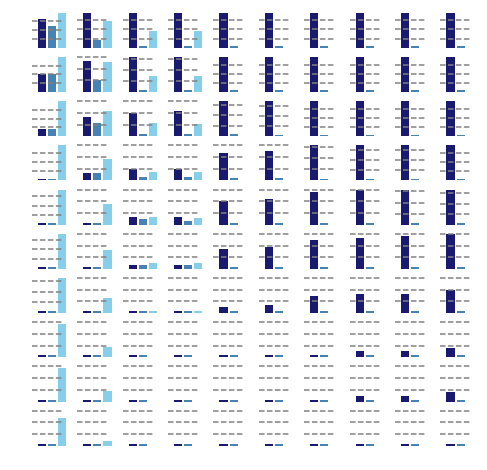

In [37]:
generate_param_topol_manifold(analyzeArgs, modelArgs, dataArgs, models, data, color_map, trainArgs["batch_size"], scaler)